# Evaluating the model
In this this notebook we evaluate the trained (2+1)D model. 

The test set consists of 130 samples, representing 20% of the full dataset.

### Setting up

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import torch
from UNet_model_2_plus_1D import UNet

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Select the model to be evaluated
model_weights_path = './model_weights_2+1D_high_res.pth'

model = UNet(n_channels=1, n_classes=1)
model.to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

<All keys matched successfully>

In [22]:
from torch import nn

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

loss_func = DiceBCELoss()

In [7]:
import torch.nn.functional as F

def downsize_64(batch):
  if (len(batch.shape) == 4):
    batch = batch.unsqueeze(0)
  num_samples = batch.shape[0]
  scale = 3
  batch = batch[:,:,::scale,::scale,::scale]
  batch = batch[:,:,:64,:64]
  zeros = torch.zeros(num_samples,1,64,64,1)
  batch = torch.cat((zeros, batch), 4)
  return batch

def downsize_128(batch):
  if (len(batch.shape) == 4):
    batch = batch.unsqueeze(0)
  num_samples = batch.shape[0]
  d = torch.linspace(-1, 1, 128)
  meshz, meshy, meshx = torch.meshgrid((d, d, d))
  grid = torch.stack((meshx, meshy, meshz), 3)
  grid = grid.unsqueeze(0)
  grid = grid.repeat_interleave(num_samples, dim=0)

  return F.grid_sample(batch, grid, align_corners=True)

In [ ]:
!pip install bids
!pip install git+https://github.com/npnl/bidsio
import bidsio

test_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[{'suffix': 'mask',
                                                'label': 'L',
                                                'desc': 'T1lesion'}],
                                data_derivatives_names=['ATLAS'],
                                target_derivatives_names=['ATLAS'],
                                batch_size=1,
                                root_dir='drive/MyDrive/big_brain/split1/test/')

### Loss

Here we pass each sample through the model to get an average loss.

In [19]:
model.eval()

x = 0
sub_total_loss = 0
total_loss = 0
for data, label in test_loader.load_batches():
  data = downsize_128(torch.Tensor(data)).to(device)
  label = downsize_128(torch.Tensor(label)).to(device)

  outputs = model(data)
  loss = loss_func(outputs, label)
  test_loss = loss.item()

  if (x % 20 == 19):
    loss_str = f'Samples {(x-19) + 1:3d}-{x + 1}\t average loss: {sub_total_loss/20 :.8f}'
    print(loss_str)
    sub_total_loss = 0

  sub_total_loss += test_loss
  total_loss += test_loss
  x += 1

total_loss = total_loss/x
print('Total loss across', x, 'samples:', total_loss)

Samples   1-20	 average loss: 0.52679496
Samples  21-40	 average loss: 0.83158413
Samples  41-60	 average loss: 0.88114618
Samples  61-80	 average loss: 0.74595096
Samples  81-100	 average loss: 0.84875344
Samples 101-120	 average loss: 0.88977946
Total loss across 130 samples: 0.7895052040998752


In [32]:
# View loss for a given sample
data, label = test_loader.load_sample(11)
data = downsize_128(torch.Tensor(data)).to(device)
label = downsize_128(torch.Tensor(label)).to(device)

with torch.no_grad():
  output = model(data)

loss = loss_func(output[0,0], label[0,0])
print('Loss:', loss.item())

Loss: 0.16587992012500763


### Visualizing the data

In [33]:
# Move back to host memory for visualization

data = data.to('cpu')
label = label.to('cpu')
output = output.to('cpu')

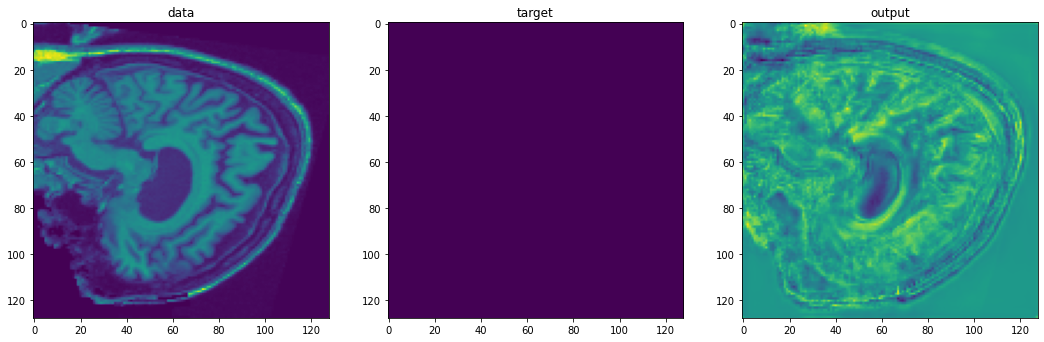

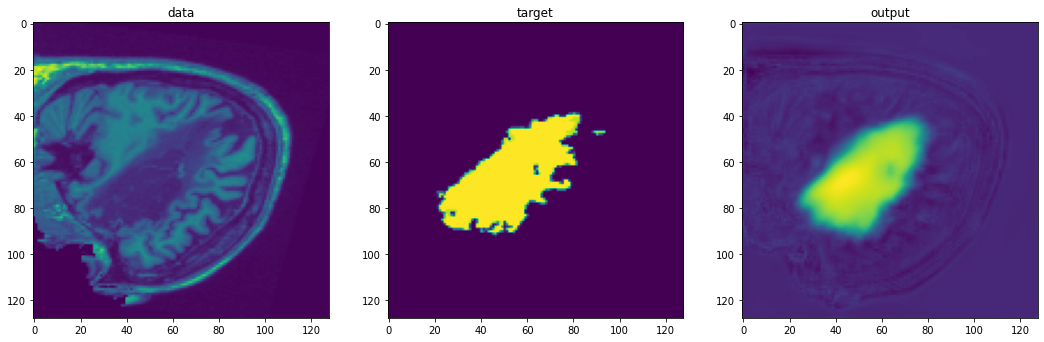

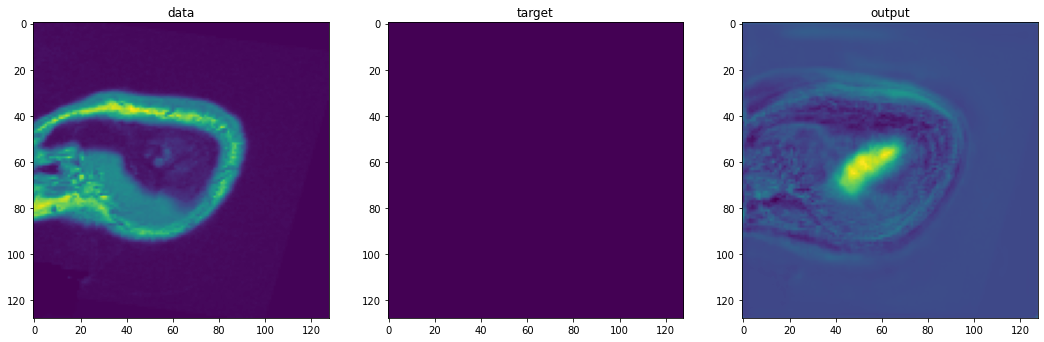

In [40]:
import matplotlib.pyplot as plt

for i in range(70,111,20):

  # scaled_out = torch.heaviside(output[0,0,i] + 1.5, torch.tensor([0.]))
  scaled_out = output[0,0,i]

  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(scaled_out);plt.title('output')

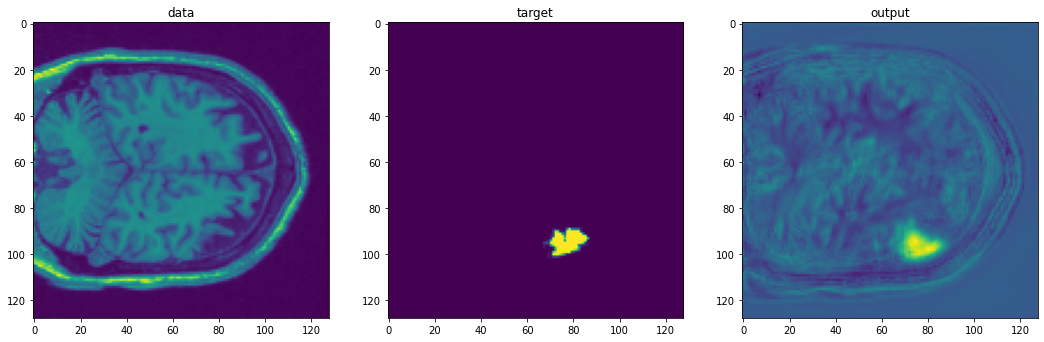

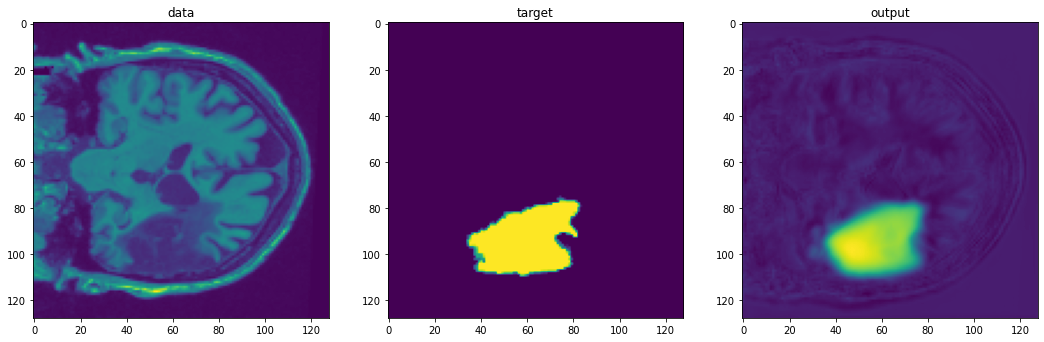

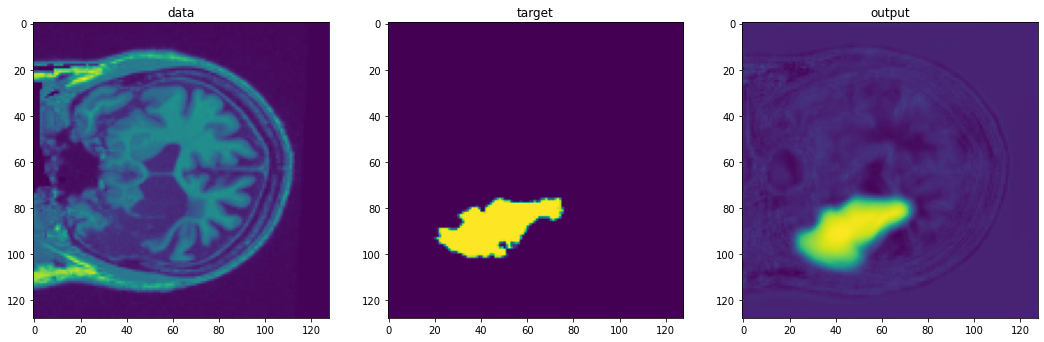

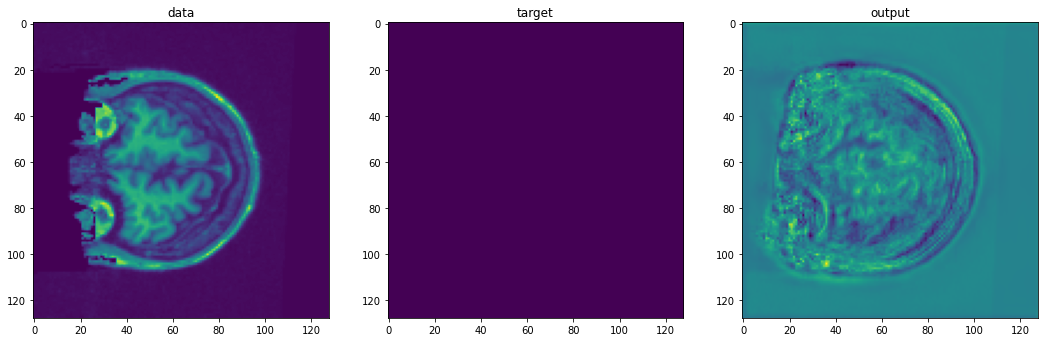

In [42]:
for i in range(40,101,20):

  # scaled_out = torch.heaviside(output[0,0,:,i] + 1.5, torch.tensor([0.]))
  scaled_out = output[0,0,:,i]

  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,:,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,:,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(scaled_out);plt.title('output')

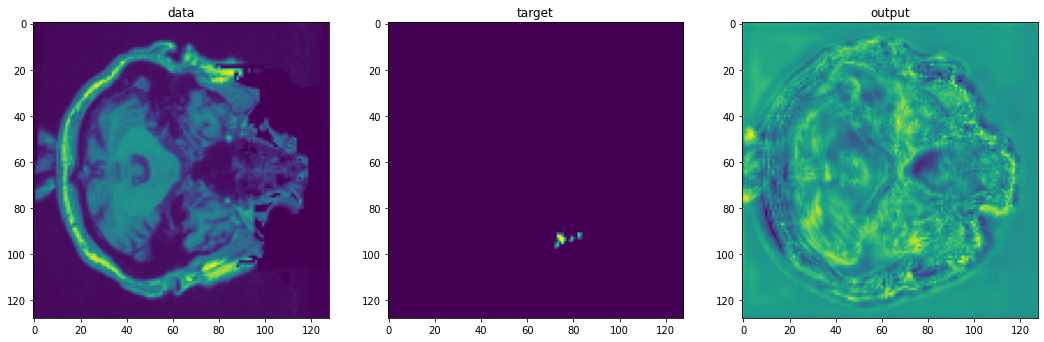

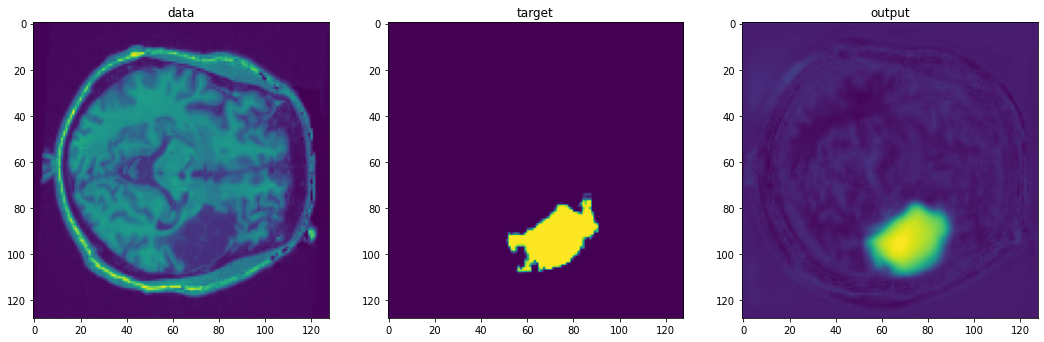

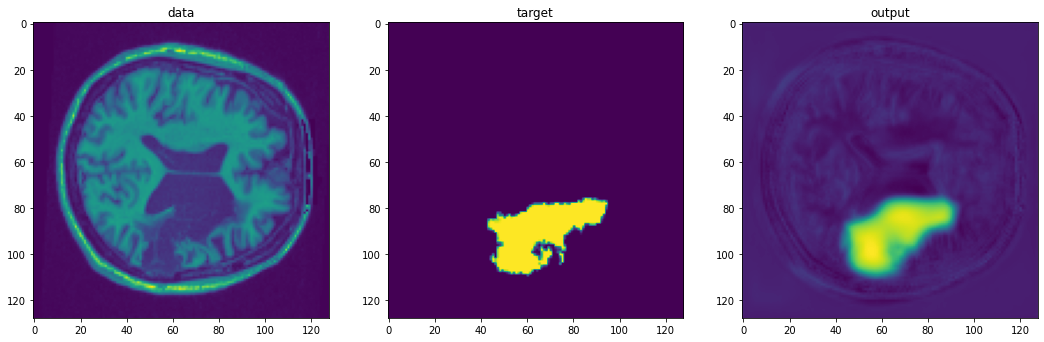

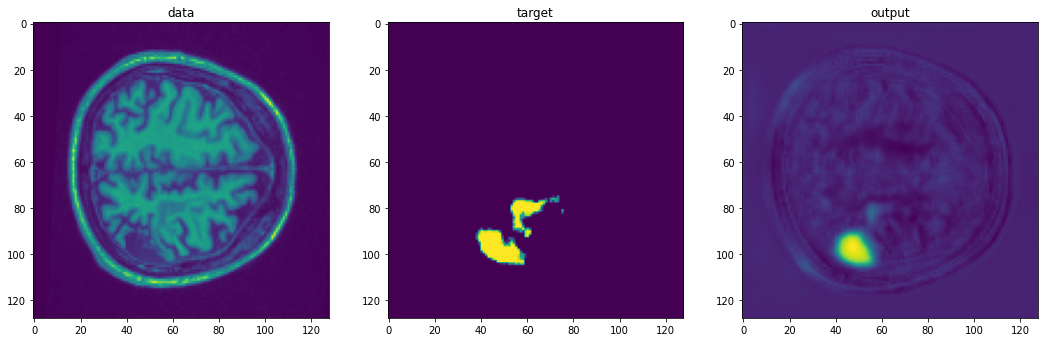

In [45]:
for i in range(20,81,20):

  # scaled_out = torch.heaviside(output[0,0,:,:,i] + 1.5, torch.tensor([0.]))
  scaled_out = output[0,0,:,:,i]

  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,:,:,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,:,:,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(scaled_out);plt.title('output')